# This notebook is the first of a series on solving the described problem. It presents the processes of data analysis and processing.

In [1]:
import os
import pandas as pd
from transformers import AutoModel, AutoTokenizer 
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity,cosine_distances
from nltk.util import ngrams
from nltk.tokenize import word_tokenize
import numpy as np
import pymorphy2
import nltk
import joblib
import re 

## Data preparation
### Extracting data from files and forming a DataFrame

In [2]:
class_0=[]
class_1=[]
for r, d, f in os.walk('data_for_nirs/0/'):
    for i in f:
        class_0.append((r+i).replace('/','\\'))
        
for r, d, f in os.walk('data_for_nirs/1/'):
    for i in f:
        class_1.append((r+i).replace('/','\\'))

In [3]:
for i in range(len(class_0)):
    with open(class_0[i],encoding="utf-8") as f:
        class_0[i]=f.read()

for i in range(len(class_1)):
    with open(class_1[i],encoding="utf-8") as f:
        class_1[i]=f.read()    
        
print(len(class_0),len(class_1))

In [4]:
all_texts=np.array(class_0+class_1)
labels=np.array([0]*len(class_0)+[1]*len(class_1))
df=pd.DataFrame({"text":all_texts,"label":labels})
df.head()

In [5]:
df.to_excel('df.xls',encoding="utf-8")
joblib.dump(df,open('df.joblib',"wb"))

### In this section, data was compiled into a single Data Frame file

## Analysis

In [2]:
df=joblib.load(open('df.joblib',"rb"))
df.head(2)

,text,label
0,"Я – Андрей Торопин – (криптовалютный инвестор,...",0
1,🚀 Дорогие партнеры! \n\nОтличная новость. \n\n...,0


In [3]:
pd.DataFrame(data = [df.isna().sum()/df.shape[0]*100],
             index=["Data Null (%)"]
            ).T.style.background_gradient(cmap='coolwarm')

,Data Null (%)
text,0.000000
label,0.000000


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 102 entries, 0 to 101
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    102 non-null    object
 1   label   102 non-null    int32 
dtypes: int32(1), object(1)
memory usage: 1.3+ KB


In [5]:
df.describe()

,label
count,102.000000
mean,0.490196
std,0.502373
min,0.000000
25%,0.000000
50%,0.000000
75%,1.000000
max,1.000000


<AxesSubplot:>

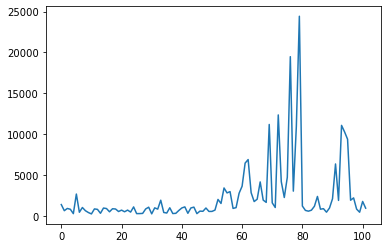

In [6]:
df.text.apply (lambda x: len(x)).plot()

### Input data has been analyzed, there is no class imbalance, it is necessary to combat emissions.

## Text preprocessing
* explicitly remove all links
* only allowed characters remain in the text: "ёйцукенгшщзхъфывапролджэячсмитьбюqwertyuiopasdfghjklzxcvbnm "

In [7]:
stop_words=joblib.load(open("stop_words.joblib","rb"))
punctuation=joblib.load(open("punctuation.joblib","rb"))
allow_chars=joblib.load(open("allow_chars.joblib","rb"))

In [8]:
def clear_patterns(text):
    patterns = [r"http[/?\S]*",
                r"(?<!\d)(?:0?[1-9]|[12][0-9]|3[01])[.-](?:0?[1-9]|1[0-2])[.-](?:19[0-9][0-9]|20[01][0-9])(?!\d)",
                r"\b\+?[7,8](\s*\d{3}\s*\d{3}\s*\d{2}\s*\d{2})\b",
                r"\s+",               
                r"\d+"]
    for i in patterns:
        text = re.sub(i, " ", text)
    return text

In [9]:
def text_prepare(text):
    global punctuation
    global stop_words
    text=text.lower()
    text=clear_patterns(text)
    # We leave only the allowed characters
    # TODO refactor via re
    text=list(text)
    size=len(text)
    i=0
    while i<size:
        if text[i] not in allow_chars: 
            del text[i]
            size-=1
        else:
            i+=1
            
    text="".join(text)
    # Tokenization
    tokenized_str = word_tokenize(text)
    # Lemmatization
    morph = pymorphy2.MorphAnalyzer()
    parsed_tokens = [morph.parse(word) for word in tokenized_str if word not in punctuation]
    normal_forms = [parsed_token[0].normal_form for parsed_token in parsed_tokens]
    # Filtering stop words
    tokens = np.array([i for i in normal_forms if i not in stop_words and i!="" ])
    return tokens

In [10]:
# before
df.text.values[1]

'🚀 Дорогие партнеры! \n\nОтличная новость. \n\n🔥🔥🔥Уже сегодня  6 - июля закрытое обучение, только для партнеров компании Union Time.\n\nСпикеры: \nРоман Погодаев\nЕлена Ватлашова\n\nРазберем темы:\n\n1. Беседа о продаже ⚡️\n\n2. Мотивация клиента 💰 \n\n\n🕐 Время мероприятия:\n19:00-21:00\n🗺 Адрес: Галактионовская, 118а Центр - «Точка Кипения»\n\n‼️ Приходить за 10 минут до начала\n\nВажно быть самому и взять с собой свою команду! \n\nСсылка на трансляцию, для других регионов: \n\nhttps://us06web.zoom.us/j/88009324556?pwd=cld3RThPNFNadmNFN2t6UXJMYVpiUT09\n\nИдентификатор конференции: 880 0932 4556\nКод доступа: 378673\n\n➕ Прочитал информацию и будешь ставь плюс! +++'

In [11]:
# after
text_prepare(df.text.values[1])

array(['дорогой', 'партнёр', 'отличный', 'новость', 'сегодня', 'июль',
       'закрытый', 'обучение', 'партнёр', 'компания', 'спикер', 'роман',
       'погодаев', 'елена', 'ватлашов', 'разобрать', 'тема', 'беседа',
       'продажа', 'мотивация', 'клиент', 'время', 'мероприятие', 'адрес',
       'галактионовский', 'центр', 'точка', 'кипение', 'приходить',
       'минута', 'начало', 'важно', 'взять', 'свой', 'команда', 'ссылка',
       'трансляция', 'регион', 'идентификатор', 'конференция', 'код',
       'доступ', 'прочитать', 'информация', 'ставить', 'плюс'],
      dtype='<U15')

In [13]:
# df["split_text"]=df.text.apply(text_prepare)
# joblib.dump(df,open('df_lem.joblib',"wb"))
df=joblib.load(open('df_lem.joblib',"rb"))
df.head(2)

,text,label,split_text
0,"Я – Андрей Торопин – (криптовалютный инвестор,...",0,"[андрей, торопин, криптовалютный, инвестор, со..."
1,🚀 Дорогие партнеры! \n\nОтличная новость. \n\n...,0,"[дорогой, партнёр, отличный, новость, сегодня,..."


## Features engineering

<AxesSubplot:>

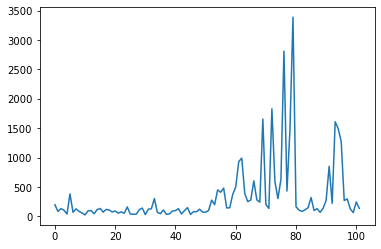

In [14]:
df["word_count"]=df.text.apply (lambda x: len(x.split()))
df["word_count"].plot()

In [15]:
df["word_count"].describe()

count     102.000000
mean      330.990196
std       543.798039
min        26.000000
25%        82.750000
50%       132.000000
75%       293.750000
max      3386.000000
Name: word_count, dtype: float64

In [16]:
df.head(2)

,text,label,split_text,word_count
0,"Я – Андрей Торопин – (криптовалютный инвестор,...",0,"[андрей, торопин, криптовалютный, инвестор, со...",199
1,🚀 Дорогие партнеры! \n\nОтличная новость. \n\n...,0,"[дорогой, партнёр, отличный, новость, сегодня,...",85


## Elimination of emissions

In [17]:
mean=df["word_count"].mean()
std=df["word_count"].std()
right_border=mean+3*std
print(f'{right_border}')

1962.3843120119845


In [18]:
df.split_text=df.split_text.apply(lambda x: x[:int(right_border)] if x.shape[0]>right_border else x)
df.text=df.split_text.apply(lambda x: " ".join(x))
df["word_count"]=df.split_text.apply (lambda x: x.shape[0])
df.describe()

,label,word_count
count,102.000000,102.000000
mean,0.490196,196.852941
std,0.502373,321.368743
min,0.000000,14.000000
25%,0.000000,45.250000
50%,0.000000,74.000000
75%,1.000000,183.750000
max,1.000000,1962.000000


<AxesSubplot:>

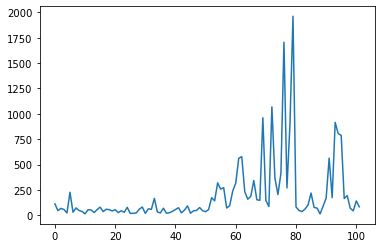

In [19]:
df.word_count.plot()

## Vectorization sentence of Bert

In [20]:
def get_text_vector(text):
    global bert_tokenizer
    global bert_model
    # Transform input tokens 
    bert_inputs = bert_tokenizer(text, return_tensors="pt",truncation=True,max_length =512,padding=True)
    # Model apply
    bert_outputs = bert_model(**bert_inputs)
    return bert_outputs.pooler_output.detach().numpy()

In [21]:
model_name = "DeepPavlov/rubert-base-cased" 
bert_model = AutoModel.from_pretrained(model_name)
bert_tokenizer = AutoTokenizer.from_pretrained(model_name)

Some weights of the model checkpoint at DeepPavlov/rubert-base-cased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [22]:
# df["sentence_vec"]=df.text.apply(lambda x: get_text_vector(x))
# joblib.dump(df,open('df__with_sentence_vec_lem.joblib',"wb"))

df=joblib.load(open('df__with_sentence_vec_lem.joblib',"rb"))
df.head(2)

,text,label,split_text,word_count,sentence_vec
0,андрей торопин криптовалютный инвестор совмест...,0,"[андрей, торопин, криптовалютный, инвестор, со...",113,"[[0.31115916, -0.18865412, 0.4612622, -0.25092..."
1,дорогой партнёр отличный новость сегодня июль ...,0,"[дорогой, партнёр, отличный, новость, сегодня,...",46,"[[0.01884312, 0.07527621, 0.31362343, 0.201069..."


In [23]:
df.sentence_vec=df.sentence_vec.apply(lambda x: x[0])
df.head(2)

,text,label,split_text,word_count,sentence_vec
0,андрей торопин криптовалютный инвестор совмест...,0,"[андрей, торопин, криптовалютный, инвестор, со...",113,"[0.31115916, -0.18865412, 0.4612622, -0.250920..."
1,дорогой партнёр отличный новость сегодня июль ...,0,"[дорогой, партнёр, отличный, новость, сегодня,...",46,"[0.01884312, 0.07527621, 0.31362343, 0.2010696..."


In [24]:
def get_n_grams(raw_text: str,ngram_count: int):
    tokenized_str = word_tokenize(raw_text)
    tokens = np.array([i for i in tokenized_str])
    
    return np.array([" ".join(list(i)) for i in ngrams(tokens,ngram_count)])

def get_key_words(text,count_output_words=5,max_n_grams=3):
    text=text_prepare(text)
    text=" ".join(text)
    all_text_vector=get_text_vector(text)
    # preparation of vectorizable n-grams
    grams=np.array([])
    for i in range(1,max_n_grams+1):
        grams=np.concatenate((grams,np.unique(get_n_grams(text,i))))
    
    # their vectorization
    vectors=np.array(list(map(get_text_vector,grams)))
    vectors=vectors.reshape(vectors.shape[0],vectors.shape[-1])
    # calculating the cosine distance
    cos_dist=np.array(list(map(lambda x: cosine_distances(x.reshape(1,-1),all_text_vector.reshape(1,-1)),vectors)))
    cos_dist=cos_dist.reshape(-1,)
    # dictionary formation with cosine distances
    dist2gram={cos_dist[i]:grams[i] for i in range(len(cos_dist))}
    dist2vec={cos_dist[i]:vectors[i] for i in range(len(cos_dist))}
    mins_dist=np.sort(cos_dist)[:count_output_words]

    return np.array([[mins_dist],[dist2gram[i] for i in mins_dist],[dist2vec[i] for i in mins_dist]],dtype=np.object)

In [25]:
# df["tr_key_words"]=df.text.apply(lambda x: get_key_words(x))
# df["key_words"]=df.tr_key_words.apply(lambda x: x[1])
# df["key_vecs"]=df.tr_key_words.apply(lambda x: x[2])
# joblib.dump(df,open('df_final.joblib',"wb"))

df=joblib.load(open('df_final.joblib',"rb"))
df.head(2)

,text,label,split_text,word_count,sentence_vec,tr_key_words,key_words,key_vecs
0,андрей торопин криптовалютный инвестор совмест...,0,"[андрей, торопин, криптовалютный, инвестор, со...",113,"[0.31115916, -0.18865412, 0.4612622, -0.250920...","[[[0.064515114, 0.06818485, 0.068751454, 0.068...","[торговать биржа иметь, инвестор свой, инвести...","[[0.24219744, -0.20182237, 0.3212388, -0.06110..."
1,дорогой партнёр отличный новость сегодня июль ...,0,"[дорогой, партнёр, отличный, новость, сегодня,...",46,"[0.01884312, 0.07527621, 0.31362343, 0.2010696...","[[[0.22614872, 0.2874428, 0.30254436, 0.304069...","[погодаев елена ватлашов, команда ссылка транс...","[[0.16501789, -0.073621735, 0.19060352, 0.2858..."


### In this part, for further research, the embeddings for the entire sentence as a whole were calculated, keywords and their embeddings were highlighted.